In [1]:
import mxnet as mx
from os import path as osp
import glob
import re
import scipy.io as sio
from mxnet import autograd, gluon, image, init, nd
from mxnet.gluon.data import DataLoader,vision
import time
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os    
import math
from scipy.stats import pearsonr
ctx=mx.gpu()
gallery_feature=[]
gallery_label=[]
num_label=0

In [6]:
def list_all_files(rootdir):
    import os
    _files = []
    list = os.listdir(rootdir) #列出文件夹下所有的目录与文件
    for i in range(0,len(list)):
        path = os.path.join(rootdir,list[i])
        if os.path.isdir(path):
            _files.extend(list_all_files(path))
        if os.path.isfile(path):
            _files.append(path)
    return _files
path_test="test/"
path_all="humanresult/"
#path_came1="video/131833"
#path_came2="video/132017"
#path_came3="video/IMG5672"
#path_came4="video/IMG5673-2"
path_came="test/"


imags_flie=list_all_files(path_came)

net = gluon.SymbolBlock.imports(symbol_file = 'jxx_res-symbol.json',ctx=mx.gpu(),
                                 param_file= 'jxx_res-0370.params',
                                 input_names=['data']
                                )
# net = gluon.SymbolBlock.imports(symbol_file = 'jxx_dens-symbol.json',ctx=mx.gpu(),
#                                  param_file= 'jxx_res-0340.params',
#                                  input_names=['data']
#                                 )

In [7]:
def img2vector(img):
    img=trans(img)
    img=nd.reshape(img,(1,3,height,width))
    _,feature=net(img.as_in_context(ctx))
    return feature

def euclidean_dist(x, y):#计算欧式距离，输入二位矩阵
    m, n = x.shape[0], y.shape[0]
    xx = nd.power(x, 2).sum(axis=1, keepdims=True).broadcast_to((m, n))
    yy = nd.power(y, 2).sum(axis=1, keepdims=True).broadcast_to((n, m)).T
    dist = xx + yy
    dist = dist - 2 * nd.dot(x, y.T)
    dist = dist.clip(a_min=1e-12, a_max=1e12).sqrt()  # for numerical stability
    return dist



from PIL import Image
from numpy import average, linalg, dot

 
def cos_similarity(vec1, vec2):

  
    a_norm=linalg.norm(vec1, 2)
    b_norm = linalg.norm(vec2, 2)
    res = dot(vec1 / a_norm, vec2 / b_norm)
    return res
 
def delfile(path):
    
#   read all the files under the folder
    fileNames = glob.glob(path + r'/*')
    
    for fileName in fileNames:
        try:
#           delete file
            os.remove( fileName)
        except:
            try:
#               delete empty folders 
                os.rmdir( fileName)
            except:
#               Not empty, delete files under folders  
                delfile( fileName)
#               now, folders are empty, delete it  
                os.rmdir( fileName)

def multiply(a,b): #a,b两个列表的数据一一对应相乘之后求和 
    sum_ab=0.0  
    temp=a*b.T
    print(temp)
    sum_ab=temp.sum(axis=0) 
    return sum_ab 
def cal_pearson(x,y):
       
    m, n = x.shape[0], y.shape[0]    
        
    n=len(x) #求x_list、y_list元素之和 
    sum_x=x.sum(axis=0)
    sum_y=y.sum(axis=0) #求x_list、y_list元素乘积之和 
    #print(sum_y)
    sum_xy=multiply(x,y) #求x_list、y_list的平方和 
    sum_xy=sum_xy[:,0].T
    #sum_x2 = sum([pow(i,2) for i in x]) 
    #sum_y2 = sum([pow(j,2) for j in y]) 
    sum_x2=nd.power(x, 2).sum(axis=1, keepdims=True).broadcast_to((m, n))
    sum_y2 = nd.power(y, 2).sum(axis=1, keepdims=True).broadcast_to((n, m)).T
    
    molecular=sum_xy-(sum_x)*(sum_y)/n #计算Pearson相关系数，molecular为分子，denominator为分母 
    print(molecular)
    denominator=((sum_x2-(sum_x**2)/n)*(sum_y2-(sum_y**2)/n)).clip(a_min=1e-12, a_max=1e12).sqrt()
    print(denominator)
    return molecular/denominator


In [8]:
#future work: 3D gallery and mean distance

height=224
width=224
save_path="res/"
delfile(save_path)
# height = 256
# width = 128

trans=vision.transforms.Compose([
    vision.transforms.Resize(size=(height,width)),
    vision.transforms.ToTensor(),
    vision.transforms.Normalize([0.485, 0.456, 0.406],
                                      [0.229, 0.224, 0.225])])


start=time.time()


for num,i in enumerate(imags_flie):
#     print(i)
    name=i.split("/")[-1]
    frame=name.split("_")[0]
    x1=name.split("_")[1]
    y1=name.split("_")[2]
    x2=name.split("_")[3]
    y2=name.split("_")[4].split(".")[0]
    img_o=image.imread(i)
#     start=time.time()
    img=trans(img_o)
    img=nd.reshape(img,(1,3,height,width))
    _,feature=net(img.as_in_context(ctx))
    if len(gallery_feature)==0:# init
        gallery_feature=feature
        gallery_label=nd.array([num_label])
        cv2.imwrite(save_path+str(0)+"_"+name,img_o.asnumpy())

#         print(num_label)
        num_label=num_label+1

    else:
      

          #进行数据降维,降成两维
        
        
        
        
        
        distmat=euclidean_dist(feature,gallery_feature)
#         m, n = feature.shape[0], gallery_feature.shape[0]
#         distmat = nd.power(feature, 2).sum(axis=1, keepdims=True).broadcast_to((m, n)) + \
#                   nd.power(gallery_feature, 2).sum(axis=1, keepdims=True).broadcast_to((n, m)).T
#         distmat = distmat - 2 * nd.dot(feature, gallery_feature.T)
        indices = nd.argsort(distmat, axis=1)
        print(distmat)
        label=indices[0][min(min(indices))]
        
        indices = nd.argsort(distmat, axis=1)
#         print(indices)
#         print(distmat[0][indices[0][min(min(indices))]])
#         print(distmat[0][indices[0][min(min(indices))]])
        if distmat[0][indices[0][min(min(indices))]]>3:
            #thresh 80     
            label=label+1
            gallery_feature=nd.concat(gallery_feature,feature,dim=0)
            gallery_label=nd.concat(gallery_label,nd.array([num_label]),dim=0)
            num_label=num_label+1
       # print(label)
#     cv2.imwrite("humanresult/human_labeled/"+str(label)+".jpg",img_o.asnumpy())
#     print("humanresult/human_labeled/"+str(label.asnumpy().astype("int")[0])+"_"+name)
#         cv2.imwrite("humanresult/testresult/"+str(label.asnumpy().astype("int")[0])+"_"+name,img_o.asnumpy())
        cv2.imwrite(save_path+str(label.asnumpy().astype("int")[0])+"_"+name,img_o.asnumpy())
    

        
        
    

        
        
        


[[0.91310215]]
<NDArray 1x1 @gpu(0)>

[[0.42653316]]
<NDArray 1x1 @gpu(0)>

[[5.3941817]]
<NDArray 1x1 @gpu(0)>

[[5.183492  1.1400229]]
<NDArray 1x2 @gpu(0)>

[[0.95036745 5.644773  ]]
<NDArray 1x2 @gpu(0)>

[[4.2524333 4.2468395]]
<NDArray 1x2 @gpu(0)>

[[1.4839895 5.6297464 4.590515 ]]
<NDArray 1x3 @gpu(0)>

[[4.1594224 3.677877  3.812704 ]]
<NDArray 1x3 @gpu(0)>

[[4.3060856 4.735688  4.2476406 3.2303767]]
<NDArray 1x4 @gpu(0)>

[[0.51210624 5.407571   4.22954    4.1976323  4.373969  ]]
<NDArray 1x5 @gpu(0)>

[[3.6228464 4.9694853 4.4554696 3.1879308 3.5058763]]
<NDArray 1x5 @gpu(0)>

[[4.338588  2.8661096 2.9377027 3.1751854 3.9533334 4.2758346]]
<NDArray 1x6 @gpu(0)>

[[4.338166  4.0276146 1.5859278 3.6908317 4.199335  4.3500824]]
<NDArray 1x6 @gpu(0)>

[[4.2800717 2.9452322 3.1458604 2.9004714 4.053216  4.1561437]]
<NDArray 1x6 @gpu(0)>

[[5.1078696 2.3269548 3.8814683 3.3955538 4.6248913 4.8767743]]
<NDArray 1x6 @gpu(0)>

[[4.7737155 1.9706712 3.67624   3.2528884 4.344491  4.4

In [ ]:
#future work: 3D gallery and mean distance

height=224
width=224
save_path="res/"
delfile(save_path)
# height = 256
# width = 128

trans=vision.transforms.Compose([
    vision.transforms.Resize(size=(height,width)),
    vision.transforms.ToTensor(),
    vision.transforms.Normalize([0.485, 0.456, 0.406],
                                      [0.229, 0.224, 0.225])])


start=time.time()


for num,i in enumerate(imags_flie):
#     print(i)
    name=i.split("/")[-1]
    frame=name.split("_")[0]
    x1=name.split("_")[1]
    y1=name.split("_")[2]
    x2=name.split("_")[3]
    y2=name.split("_")[4].split(".")[0]
    img_o=image.imread(i)
#     start=time.time()
    img=trans(img_o)
    img=nd.reshape(img,(1,3,height,width))
    _,feature=net(img.as_in_context(ctx))
    if len(gallery_feature)==0:# init
        gallery_feature=feature
        gallery_label=nd.array([num_label])
        cv2.imwrite(save_path+str(0)+"_"+name,img_o.asnumpy())

#         print(num_label)
        num_label=num_label+1

    else:
      

          #进行数据降维,降成两维
        
        
        
        
        
        distmat=euclidean_dist(feature,gallery_feature)
#         m, n = feature.shape[0], gallery_feature.shape[0]
#         distmat = nd.power(feature, 2).sum(axis=1, keepdims=True).broadcast_to((m, n)) + \
#                   nd.power(gallery_feature, 2).sum(axis=1, keepdims=True).broadcast_to((n, m)).T
#         distmat = distmat - 2 * nd.dot(feature, gallery_feature.T)
        indices = nd.argsort(distmat, axis=1)
        print(distmat)
        label=indices[0][min(min(indices))]
        
        indices = nd.argsort(distmat, axis=1)
#         print(indices)
#         print(distmat[0][indices[0][min(min(indices))]])
#         print(distmat[0][indices[0][min(min(indices))]])
        if distmat[0][indices[0][min(min(indices))]]>3:
            #thresh 80     
            label=label+1
            gallery_feature=nd.concat(gallery_feature,feature,dim=0)
            gallery_label=nd.concat(gallery_label,nd.array([num_label]),dim=0)
            num_label=num_label+1
       # print(label)
#     cv2.imwrite("humanresult/human_labeled/"+str(label)+".jpg",img_o.asnumpy())
#     print("humanresult/human_labeled/"+str(label.asnumpy().astype("int")[0])+"_"+name)
#         cv2.imwrite("humanresult/testresult/"+str(label.asnumpy().astype("int")[0])+"_"+name,img_o.asnumpy())
        cv2.imwrite(save_path+str(label.asnumpy().astype("int")[0])+"_"+name,img_o.asnumpy())
    

        
        
    

        
        
        

In [5]:
#future work: 3D gallery and mean distance

height=224
width=224
save_path="res/"
delfile(save_path)
# height = 256
# width = 128

trans=vision.transforms.Compose([
    vision.transforms.Resize(size=(height,width)),
    vision.transforms.ToTensor(),
    vision.transforms.Normalize([0.485, 0.456, 0.406],
                                      [0.229, 0.224, 0.225])])


start=time.time()


for num,i in enumerate(imags_flie):
#     print(i)
    name=i.split("/")[-1]
    frame=name.split("_")[0]
    x1=name.split("_")[1]
    y1=name.split("_")[2]
    x2=name.split("_")[3]
    y2=name.split("_")[4].split(".")[0]
    img_o=image.imread(i)
#     start=time.time()
    img=trans(img_o)
    img=nd.reshape(img,(1,3,height,width))
    _,feature=net(img.as_in_context(ctx))
    if len(gallery_feature)==0:# init
        gallery_feature=feature
        gallery_label=nd.array([num_label])
        cv2.imwrite(save_path+str(0)+"_"+name,img_o.asnumpy())

#         print(num_label)
        num_label=num_label+1

    else:
      

          #进行数据降维,降成两维
        
        
        #print(feature)
        #print(gallery_feature)
        distmat=cal_pearson(feature,gallery_feature)
      #  distmat=pearson(feature,gallery_feature)
#         m, n = feature.shape[0], gallery_feature.shape[0]
#         distmat = nd.power(feature, 2).sum(axis=1, keepdims=True).broadcast_to((m, n)) + \
#                   nd.power(gallery_feature, 2).sum(axis=1, keepdims=True).broadcast_to((n, m)).T
#         distmat = distmat - 2 * nd.dot(feature, gallery_feature.T)

        indices = nd.argsort(distmat, axis=1)
        print(distmat)
        label=indices[0][min(max(indices))]
        
        indices = nd.argsort(distmat, axis=1)
#        print(indices)
#         print(distmat[0][indices[0][min(min(indices))]])
#         print(distmat[0][indices[0][min(min(indices))]])
        if distmat[0][indices[0][min(max(indices))]]>0.5:
            #thresh 80     
            label=label+1
            gallery_feature=nd.concat(gallery_feature,feature,dim=0)
            gallery_label=nd.concat(gallery_label,nd.array([num_label]),dim=0)
            num_label=num_label+1
        print(label)
#     cv2.imwrite("humanresult/human_labeled/"+str(label)+".jpg",img_o.asnumpy())
#     print("humanresult/human_labeled/"+str(label.asnumpy().astype("int")[0])+"_"+name)
#         cv2.imwrite("humanresult/testresult/"+str(label.asnumpy().astype("int")[0])+"_"+name,img_o.asnumpy())
        cv2.imwrite(save_path+str(label.asnumpy().astype("int")[0])+"_"+name,img_o.asnumpy())
    

        
        
    

        
        
        

NameError: name 'delfile' is not defined

In [30]:
for num,i in enumerate(imags_flie):
    
    name=i.split("/")[-1]
    frame=name.split("_")[0]
    x1=name.split("_")[1]
    y1=name.split("_")[2]
    x2=name.split("_")[3]
    y2=name.split("_")[4].split(".")[0]
    print
    print(name)
    

000515_0890_0461_1004_0811.jpg
000007_0806_0407_0948_0781.jpg
000192_0922_0454_1120_1011.jpg
000703_0927_0475_1070_0855.jpg
000582_0924_0481_1029_0813.jpg
000171_0917_0490_1089_0942.jpg
000717_0914_0459_1059_0886.jpg
000624_0921_0494_1040_0825.jpg
000716_0915_0460_1060_0885.jpg
000739_0912_0453_1068_0909.jpg
000583_0922_0483_1027_0812.jpg
000633_0935_0492_1055_0836.jpg
000715_0916_0462_1061_0884.jpg
000770_0908_0446_1101_0996.jpg
000601_0929_0501_1027_0807.jpg
000555_0951_0476_1038_0815.jpg
000467_0882_0427_1054_0991.jpg
000643_0939_0489_1061_0839.jpg
000443_0712_0332_1049_1079.jpg
000421_0072_0023_1013_1079.jpg
000610_0931_0503_1034_0813.jpg
000577_0935_0473_1040_0819.jpg
000264_0976_0348_1473_1074.jpg
000030_0814_0409_0945_0792.jpg
000255_0966_0362_1424_1079.jpg
000301_1207_0114_1916_1079.jpg
000188_0924_0463_1120_0998.jpg
000619_0926_0498_1031_0814.jpg
000129_0916_0539_1059_0921.jpg
000307_1395_0046_1914_1079.jpg
000471_0883_0421_1055_0946.jpg
000655_0930_0480_1057_0849.jpg
000592_0

In [31]:
print(gallery_feature)
print(gallery_label)


[[0.33347082 0.10787898 0.01284049 ... 0.10774888 0.00442613 0.1024223 ]]
<NDArray 1x2048 @gpu(0)>

[0.]
<NDArray 1 @cpu(0)>



[[5.1031215e-03 0.0000000e+00 2.9812995e-07 ... 1.1020555e+00
  2.8011394e-01 2.0193367e+00]]
<NDArray 1x1024 @gpu(0)>



[[6.262171]]
<NDArray 1x1 @gpu(0)>

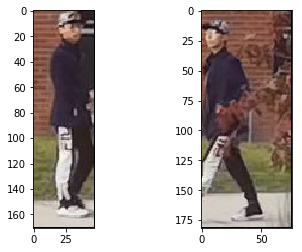

In [17]:
img1=image.imread("humanresult_0\\humanresult\\001517_1282_0388_1330_0559.jpg")
plt.subplot(121)
plt.imshow(img1.asnumpy())
vector1=img2vector(img1)

# print(vector1)
img2=image.imread("humanresult_0\\humanresult\\001768_1364_0386_1440_0568.jpg")
vector2=img2vector(img2)
plt.subplot(122)
plt.imshow(img2.asnumpy())
print(vector1)

# m, n = vector1.shape[0], vector2.shape[0]
# distmat = nd.power(vector1, 2).sum(axis=1, keepdims=True).broadcast_to((m, n)) + \
#                   nd.power(vector2, 2).sum(axis=1, keepdims=True).broadcast_to((n, m)).T
# distmat = distmat - 2 * nd.dot(vector1, vector2.T)
# print(distmat)

# cos_similarity(vector1[0].asnumpy(),vector2[0].asnumpy())
euclidean_dist(vector1,vector2)

# dismat=euclidean_dist(vector2,gallery_feature)
# dismat
# #旭伟相同是1.2327422
# #旭伟，我

In [ ]:

# for num,i in enumerate(imags_flie):
#     img=image.imread(i)
    
#     img2=image.imread(i)
#     vector2=img2vector(img2)
#     print(euclidean_dist(vector1,vector2))

In [ ]:
m, n = vector1.shape[0], gallery_feature.shape[0]

distmat = nd.power(vector2, 2).sum(axis=1, keepdims=True).broadcast_to((m, n)) + \
          nd.power(gallery_feature, 2).sum(axis=1, keepdims=True).broadcast_to((n, m)).T
distmat = distmat - 2 * nd.dot(vector2, gallery_feature.T)
indices = nd.argsort(distmat, axis=1)
print(distmat)

print(distmat[0][indices[0][min(min(indices))]])

In [ ]:
# height=224
# width=224

# for num,i in enumerate(imags_flie):
#     name=i.split("\\")[-1]
#     frame=name.split("_")[0]
#     x1=name.split("_")[1]
#     y1=name.split("_")[2]
#     x2=name.split("_")[3]
#     y2=name.split("_")[4].split(".")[0]
# #     img=image.imread(i)
#     queryloader = DataLoader(
#         ImageData(i, TestTransform(height, width)),
#         batch_size=1, num_workers=0,
#         )
#     for i,inputs in enumerate(queryloader):
        
        
#         img=inputs[0].as_in_context(ctx)
#         print(inputs)
#         _,feature=net(img)
#         if len(gallery)==0:
#             gallery_feature=feature
#         else:
#             gallery_feature=nd.concat(gallery_feature,feature,dim=0)
#     break
#     if num==10:
#         break

In [ ]:
# gallery_feature=nd.concat([],[],dim=0)